In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from astropy import units as u
from astropy import constants as const
from jupyterthemes import jtplot #These two lines can be skipped if you are not using jupyter themes
jtplot.reset()

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.314)
import scipy as sp
import multiprocessing as mp

import time
start_total = time.time()

%matplotlib notebook

In [2]:
zl = 0.2; zs = 1.2

Dl = cosmo.angular_diameter_distance(zl)   
Ds = cosmo.angular_diameter_distance(zs)    
Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)

print('Dl: ',Dl); print('Ds: ',Ds); print('Dls: ',Dls)
print('G: ',(const.G).value ,(const.G).unit)
G = const.G
rho_crit = (cosmo.critical_density(zl)).to(u.kg/u.m**3)
print('rho_crit :',rho_crit)
c_light = (const.c).to(u.cm/u.second)
print('c_light :', c_light)

#r0 = 10*u.kpc
r0 = 10.0*u.kpc
#r0 = 0.1*u.kpc
print('r0:', r0)
pi = np.pi

def scale_radius(v,Dl,Ds,Dls):                               #this is e0 in eq 3.42 meneghetti, eq 1 barnacka 2014
    return (4.*pi*v**2/c_light**2*Dl*Dls/Ds).decompose()
def theta_E_SIS():
    'in arcsec'
    pre_theta_E = (scale_radius(v,Dl,Ds,Dls)/Dl).decompose()
    return pre_theta_E*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())

v = 180 *u.km/u.s
ss_r = scale_radius(v,Dl,Ds,Dls) 
print('scale radius (m): ',ss_r)
print('scale radius (kpc): ',ss_r.to(u.kpc))
print('theta_E: ',theta_E_SIS() ,'arcsec')

theta_E_num = theta_E_SIS()
elipt = eta = 0.3
re = (const.e.esu**2/const.m_e/(c_light**2)).decompose()
print('Classic electron radius: ',re)

Dl:  705.4019455128785 Mpc
Ds:  1760.3796178766652 Mpc
Dls:  1375.6149203241862 Mpc
G:  6.6743e-11 m3 / (kg s2)
rho_crit : 1.0483397591328813e-26 kg / m3
c_light : 29979245800.0 cm / s
r0: 10.0 kpc
scale radius (m):  7.705329461274929e+19 m
scale radius (kpc):  2.49712721364453 kpc
theta_E:  0.7301786792241515 arcsec
Classic electron radius:  2.817940324670788e-15 m


In [3]:
nu = 130.0 * u.MHz
omega = nu*(1.+zl)*2*np.pi
#n0 = 40./(u.cm)**(3)
n0 = 300./(u.cm)**(3)

In [4]:
theta_0 = (r0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 
print('Angular scale radius (theta_0 = r0/Dl): ',theta_0, 'arcsec')

Angular scale radius (theta_0 = r0/Dl):  2.9240748137875747 arcsec


In [5]:
A = 2.00744300029693
B = 1.5887225542022732
C = 1.4308204791467736


psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

psi0_plasma_num = psi0_plasma.value
theta_E = theta_E_SIS().value
theta_0_num = theta_0.value

phi = np.linspace(0,2*np.pi, 3000)
r = theta_E
deltab_10 = .1
deltab_20 = .2
delta_rs = .07

In [6]:
from plasma_jet_class import sieplasmajet

In [7]:
sie_plasma = sieplasmajet(theta_E, r, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)
sie_plasma.psi_plasma_func()
sie_plasma.delta_r()

/home/tomi/Documentos/Fisica/Tesis/lens-grav/perturbative/plasma_jet_class.py:66: RuntimeWarning: invalid value encountered in sqrt
  delta_r_1 = 1/(1 - d2psi0_dr2 )*(ddpsi_dr + deltab_10*np.cos(self.phi) + deltab_20*np.sin(self.phi) + np.sqrt(Delta))
/home/tomi/Documentos/Fisica/Tesis/lens-grav/perturbative/plasma_jet_class.py:67: RuntimeWarning: invalid value encountered in sqrt
  delta_r_2 = 1/(1 - d2psi0_dr2 )*(ddpsi_dr + deltab_10*np.cos(self.phi) + deltab_20*np.sin(self.phi) - np.sqrt(Delta))


In [8]:
sie_plasma.psi_plasma

0.4379799012502185

In [9]:
delta_r_arr = [sie_plasma.delta_r_1 , sie_plasma.delta_r_2] 

<IPython.core.display.Javascript object>


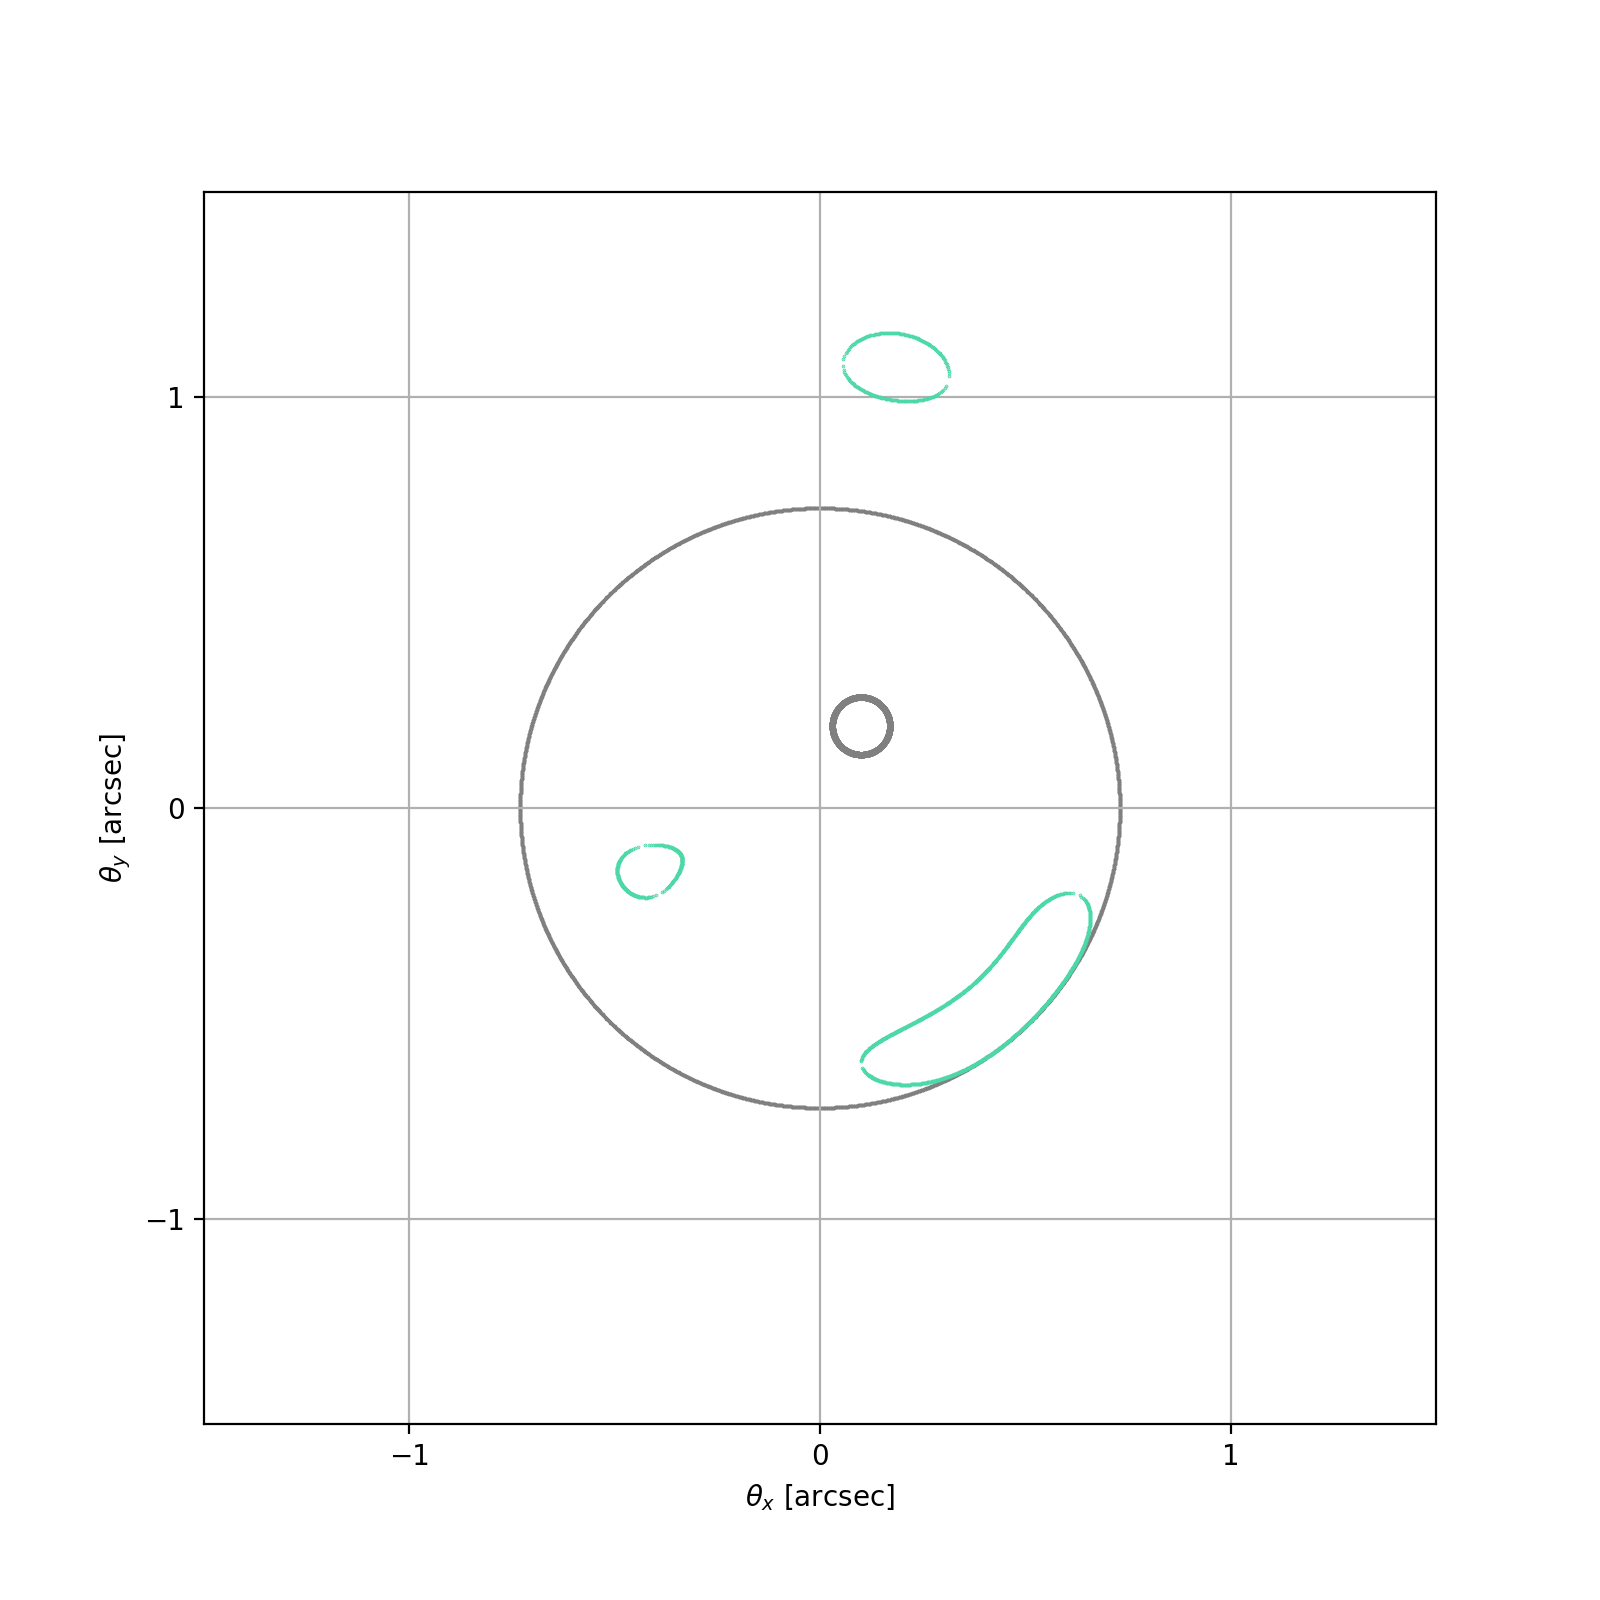

In [10]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

radii = r + delta_r_arr

plt.scatter(radii*np.cos(phi),radii*np.sin(phi),s = .1,zorder = 2 , color = '#4cd8a7')
plt.scatter(r*np.cos(phi),r*np.sin(phi),s = .1,zorder = 1, color = 'grey')
plt.scatter(delta_rs*np.cos(phi) + deltab_10, delta_rs*np.sin(phi) + deltab_20,s = 1,zorder = 2, color = 'grey')
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.grid()
plt.show()

In [11]:
eta = 0.3
nu = 130.0 * u.MHz
omega = nu*(1.+zl)*2*np.pi
n0 = 300./(u.cm)**(3)

psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

psi0_plasma_num = psi0_plasma.value
theta_E = theta_E_SIS().value
theta_0_num = theta_0.value

deltab_10 = .1
deltab_20 = .2
delta_rs = .07

<IPython.core.display.Javascript object>


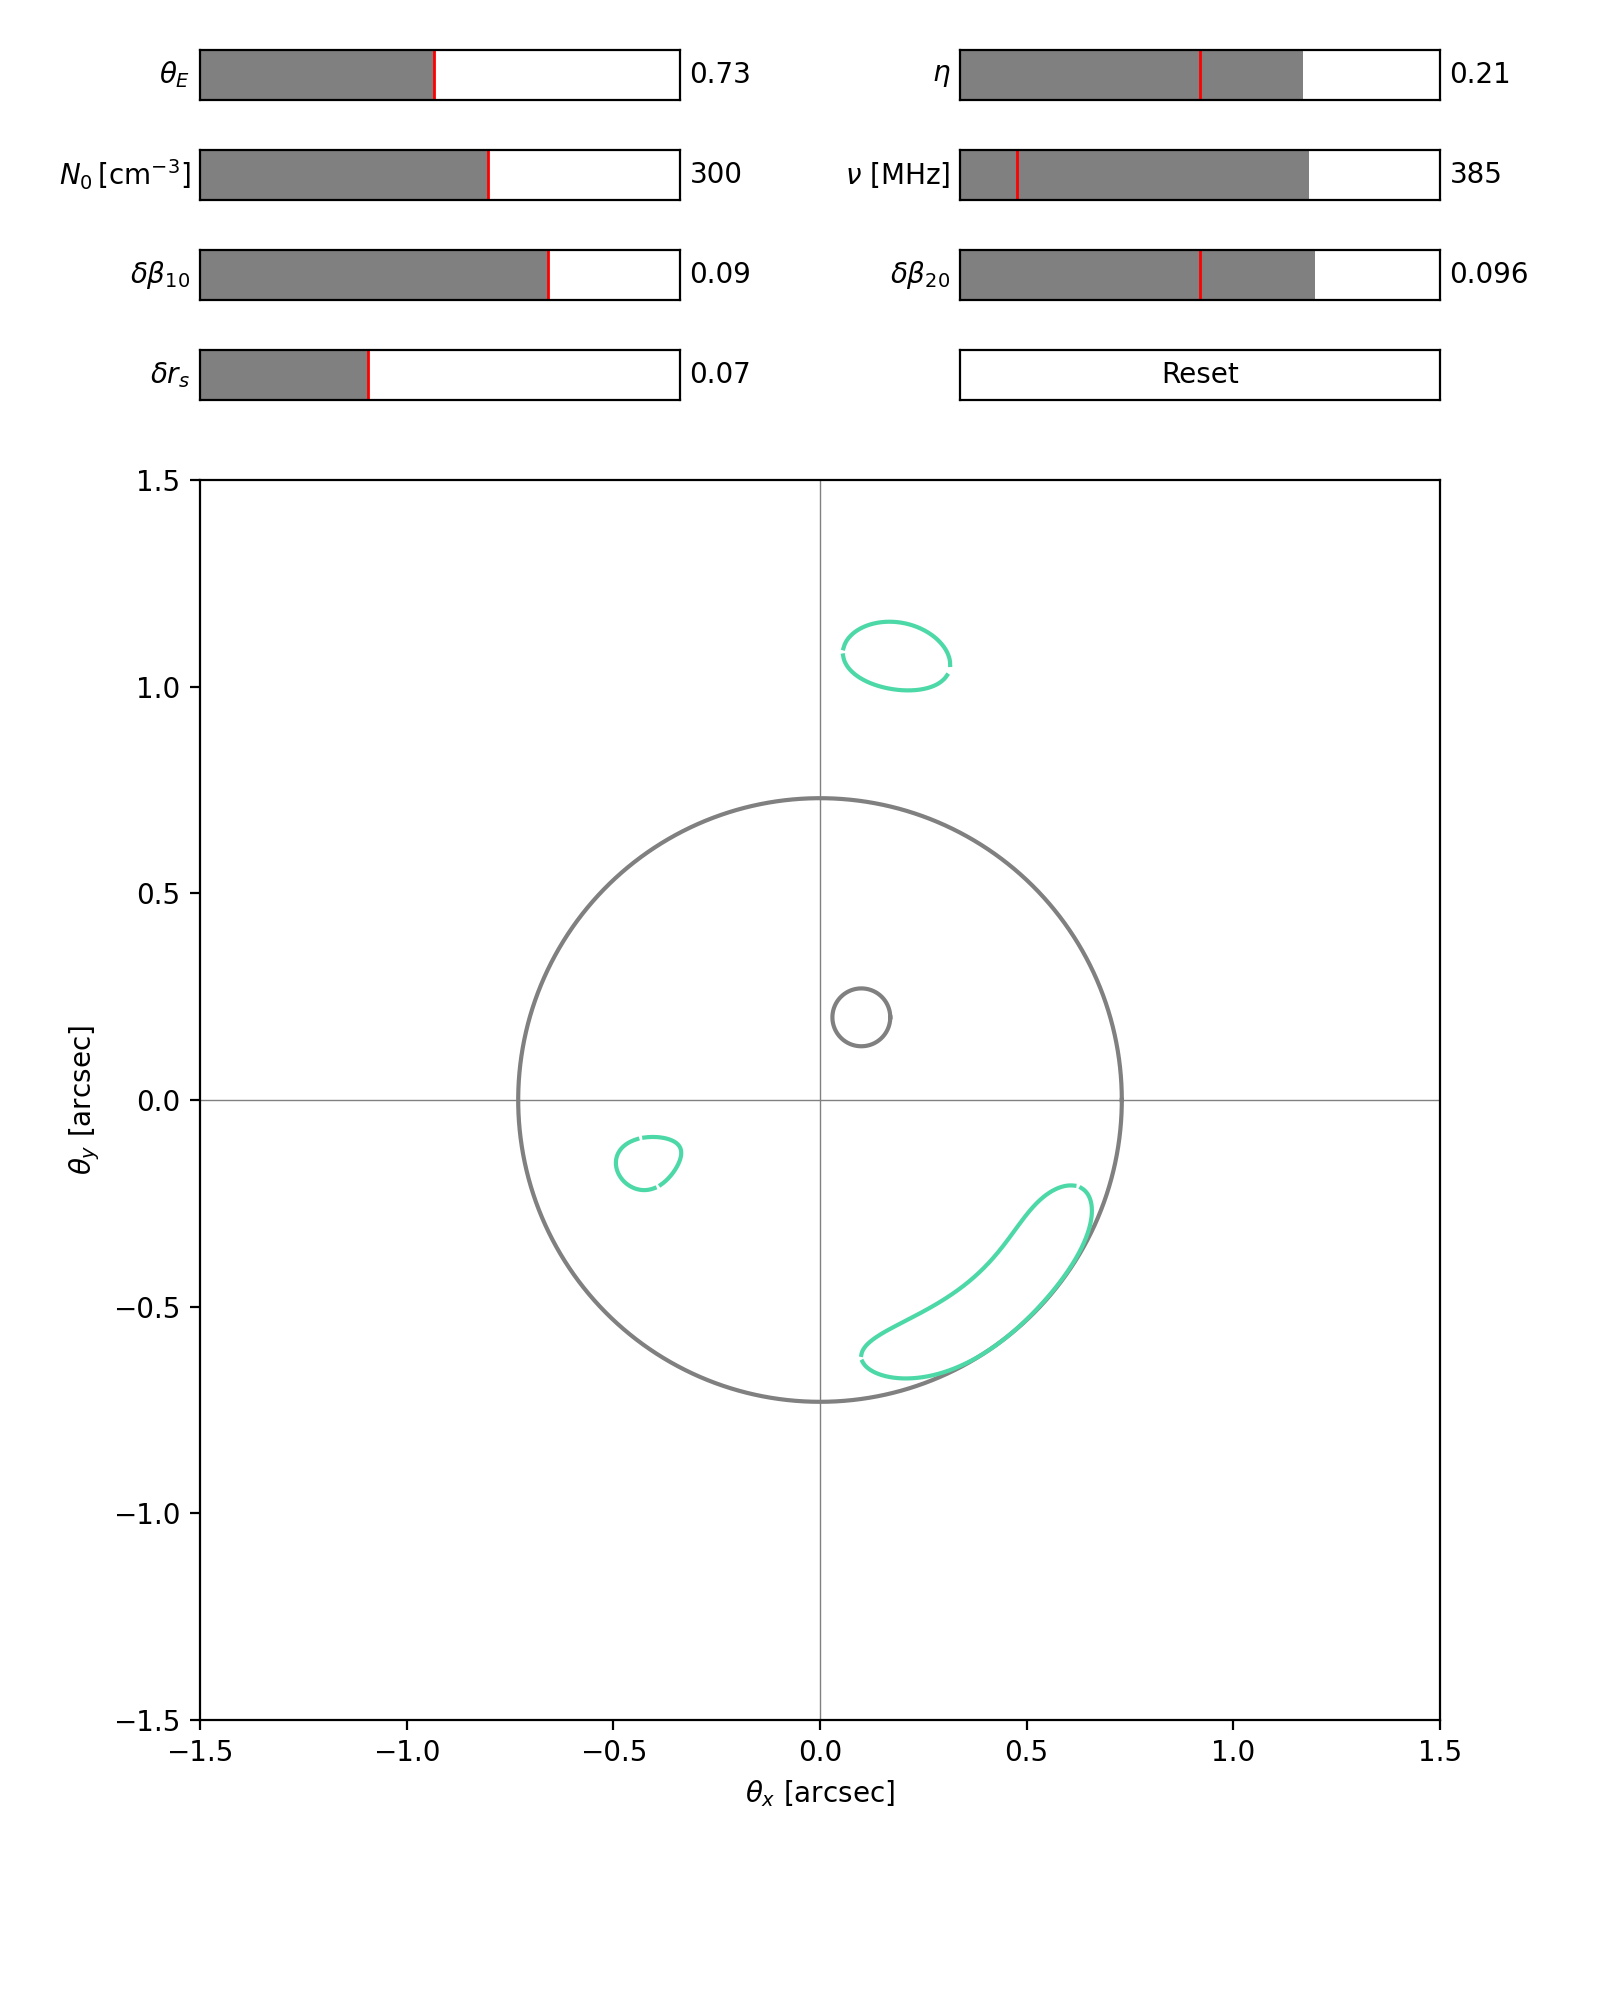

0

In [12]:
fig = plt.figure(figsize=(8, 10),num="LENSTOMI")
ax = fig.add_subplot(111)
fig.subplots_adjust(bottom=0.1, top=0.8)

ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])

plt.gca().set_aspect('equal', adjustable='box')

ax_theta_E = fig.add_axes([0.125, 0.95, 0.3, 0.025])
ax_eta = fig.add_axes([0.6, 0.95, 0.3, 0.025])
ax_n0 = fig.add_axes([0.125, 0.9, 0.3, 0.025])
ax_nu = fig.add_axes([0.6, 0.9, 0.3, 0.025])
ax_db10 = fig.add_axes([0.125, 0.85, 0.3, 0.025])
ax_db20 = fig.add_axes([0.6, 0.85, 0.3, 0.025])
ax_drs = fig.add_axes([0.125, 0.8, 0.3, 0.025])

s_theta_E = Slider(ax=ax_theta_E, label=r'$\theta_{E}$', valmin=0, valmax=1.5,valinit = 0.73,
              valfmt='%1.2g', facecolor='grey')
s_eta = Slider(ax=ax_eta,label= r'$\eta$', valmin=0, valmax=0.3, 
             valinit=0.15, valfmt='%3.2g', facecolor='grey')
s_n0 = Slider(ax=ax_n0,label= '$N_0 \, [\mathrm{cm}^{-3}] $', valmin=0, valmax=500, 
             valinit=300, valfmt='%i', facecolor='grey')
s_nu = Slider(ax=ax_nu,label= r'$\nu$ [MHz]', valmin=80, valmax=500, 
             valinit=130, valfmt='%i', facecolor='grey')
s_drs = Slider(ax=ax_drs,label= '$\delta r_{s}$', valmin=0, valmax=0.2, 
             valinit=0.07, valfmt='%1.2g', facecolor='grey')
s_db10 = Slider(ax=ax_db10,label= r'$\delta\beta_{10}$', valmin=-0.2, valmax=0.2, 
             valinit=0.09, valfmt='%1.2g', facecolor='grey')
s_db20 = Slider(ax=ax_db20,label= r'$\delta\beta_{20}$', valmin=-0.2, valmax=0.2, 
             valinit=0, valfmt='%1.2g', facecolor='grey')


radii_1 = theta_E + sie_plasma.delta_r_1
radii_2 = theta_E + sie_plasma.delta_r_2

f_d1, = ax.plot(radii_1*np.cos(phi),radii_1*np.sin(phi),zorder = 2 , color = '#4cd8a7')
f_d2, = ax.plot(radii_2*np.cos(phi),radii_2*np.sin(phi),zorder = 2 , color = '#4cd8a7')
f_d3, = ax.plot(r*np.cos(phi),r*np.sin(phi),zorder = 1, color = 'grey')
f_d4, = ax.plot(delta_rs*np.cos(phi) + deltab_10, delta_rs*np.sin(phi) + deltab_20,zorder = 2, color = 'grey')



ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
ax.axhline(0, linestyle='-',lw =0.5 ,color='grey') # horizontal lines
ax.axvline(0, linestyle='-',lw =0.5, color='grey') # vertical lines


def update(val):
    
    print('inside func')
    
    theta_E = s_theta_E.val
    eta = s_eta.val  
    n0 = (s_n0.val)/(u.cm)**(3)
    nu = (s_nu.val)*u.MHz
    delta_rs = s_drs.val
    deltab_10 = s_db10.val
    deltab_20 = s_db20.val

    omega = nu*(1.+zl)*2*np.pi
    psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()
    
    psi0_plasma_num = psi0_plasma.value
    
    sie_plasma = sieplasmajet(theta_E, r, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)
    sie_plasma.psi_plasma_func()
    sie_plasma.delta_r()
    
    radii_1 = theta_E + sie_plasma.delta_r_1
    radii_2 = theta_E + sie_plasma.delta_r_2
    
    f_d1.set_data(radii_1*np.cos(phi),radii_1*np.sin(phi),zorder = 2 , color = '#4cd8a7')
    f_d2.set_data(radii_2*np.cos(phi),radii_2*np.sin(phi),zorder = 2 , color = '#4cd8a7')
    f_d3.set_data(r*np.cos(phi),r*np.sin(phi),zorder = 1, color = 'grey')
    f_d4.set_data(delta_rs*np.cos(phi) + deltab_10, delta_rs*np.sin(phi) + deltab_20,zorder = 2, color = 'grey')
    fig.canvas.draw_idle()
    
    
s_theta_E.on_changed(update)
s_eta.on_changed(update)
s_n0.on_changed(update) 
s_nu.on_changed(update)
s_drs.on_changed(update)
s_db10.on_changed(update)
s_db20.on_changed(update)

resetax = plt.axes([0.6, 0.8, 0.3, 0.025])
button = Button(resetax, 'Reset', color='white', hovercolor='0.975')

def reset(event):
    s_theta_E.reset()
    s_eta.reset()
    s_n0.reset()
    s_nu.reset()
    s_drs.reset()
    s_db10.reset()
    s_db20.reset()
button.on_clicked(reset)

In [13]:
radius_3 = 0.5551103128497743

n = 200
t = np.linspace(0,1.3*radius_3*np.sqrt(2)/2,n)
t2 = np.linspace(0,1.3*1.11*radius_3*np.sqrt(2)/2,n)
a = 1.0
b = 0.9

x0 = -0.2*radius_3
y0 = -0.185*radius_3

x1 = 0.01*radius_3
y1 = 0.01*radius_3
x_source_1 = t + x0
y_source_1 = a*t + y0
x_source_2 = t2 + x0 + x1
y_source_2 = b*t2 + y0 - y1
        
mesh_x = []
mesh_y = []
n1 = 7  #n1 lower implies a higher number of points
for j in range(len(x_source_1)):
    for i in range(int(j/n1)):
        mesh_x.append(x_source_1[j]+j*0.02/n)
        z = np.linspace(y_source_2[j]-j*0.02/n, y_source_1[j]+j*0.02/n,int(j/n1))
        mesh_y.append(z[i])
        
mesh__x = []
mesh__y = []
limit = len(mesh_x) - int(n/n1)
for i in range(61):
    mesh_x[i] = 0.
    mesh_y[i] = 0.
for i in range(len(mesh_x)):
    if np.sqrt(mesh_x[i]**2+mesh_y[i]**2) < np.sqrt(mesh_x[limit]**2+mesh_y[limit]**2) and np.sqrt(mesh_x[i]**2+mesh_y[i]**2)>0.001:
        mesh__x.append(mesh_x[i])
        mesh__y.append(mesh_y[i])
        
mesh_x = mesh__x
mesh_y = mesh__y

k = np.array(mesh_y).argmin()
mesh_x[k] = 0
mesh_y[k] = 0

In [14]:
# count blobes from smaller to bigger
alpha = -(np.pi/4 + 1.5* np.pi/180)

rx_1 = 0.017/2
ry_1 = 5*rx_1
cx_1 = 0.12
cy_1 = 0.11+0.01*radius_3
rx_2 = 0.022/2
ry_2 = 5*rx_1
cx_2 = 0.18 
cy_2 = 0.167+0.01*radius_3
rx_3 = 0.027/2
ry_3 = 5*rx_3
cx_3 = 0.26
cy_3 = 0.245+0.01*radius_3 
rx_4 = 0.045/2
ry_4 = 4*rx_4
cx_4 = 0.37 
cy_4 = 0.35+0.01*radius_3   
mesh_light = []
for i in range(len(mesh_x)):
    if ( (mesh_x[i]-cx_1)*np.cos(alpha) + (mesh_y[i]-cy_1)*np.sin(alpha) )**2/rx_1**2 + \
( (mesh_x[i]-cx_1)*np.sin(alpha) - (mesh_y[i]-cy_1)*np.cos(alpha) )**2/ry_1**2 < 1:
        r = np.sqrt(((mesh_x[i]-cx_1)*np.cos(alpha) + (mesh_y[i]-cy_1)*np.sin(alpha) )**2/rx_1**2 + \
( (mesh_x[i]-cx_1)*np.sin(alpha) - (mesh_y[i]-cy_1)*np.cos(alpha) )**2/ry_1**2)
        light = np.exp(-r**2)
        mesh_light.append(light)
    elif ( (mesh_x[i]-cx_2)*np.cos(alpha) + (mesh_y[i]-cy_2)*np.sin(alpha) )**2/rx_2**2 + \
( (mesh_x[i]-cx_2)*np.sin(alpha) - (mesh_y[i]-cy_2)*np.cos(alpha) )**2/ry_2**2 < 1:
        r = np.sqrt(((mesh_x[i]-cx_2)*np.cos(alpha) + (mesh_y[i]-cy_2)*np.sin(alpha) )**2/rx_2**2 + \
( (mesh_x[i]-cx_2)*np.sin(alpha) - (mesh_y[i]-cy_2)*np.cos(alpha) )**2/ry_2**2)
        light = np.exp(-r**2)
        mesh_light.append(light)
    elif ( (mesh_x[i]-cx_3)*np.cos(alpha) + (mesh_y[i]-cy_3)*np.sin(alpha) )**2/rx_3**2 + \
( (mesh_x[i]-cx_3)*np.sin(alpha) - (mesh_y[i]-cy_3)*np.cos(alpha) )**2/ry_3**2 < 1:
        r = np.sqrt(((mesh_x[i]-cx_3)*np.cos(alpha) + (mesh_y[i]-cy_3)*np.sin(alpha) )**2/rx_3**2 + \
( (mesh_x[i]-cx_3)*np.sin(alpha) - (mesh_y[i]-cy_3)*np.cos(alpha) )**2/ry_3**2)
        light = np.exp(-r**2)
        mesh_light.append(light)
    elif ( (mesh_x[i]-cx_4)*np.cos(alpha) + (mesh_y[i]-cy_4)*np.sin(alpha) )**2/rx_4**2 + \
( (mesh_x[i]-cx_4)*np.sin(alpha) - (mesh_y[i]-cy_4)*np.cos(alpha) )**2/ry_4**2 < 1:
        r = np.sqrt(((mesh_x[i]-cx_4)*np.cos(alpha) + (mesh_y[i]-cy_4)*np.sin(alpha) )**2/rx_4**2 + \
( (mesh_x[i]-cx_4)*np.sin(alpha) - (mesh_y[i]-cy_4)*np.cos(alpha) )**2/ry_4**2)
        light = np.exp(-r**2)
        mesh_light.append(light)    
    else:
        light = 1/np.e
        mesh_light.append(light)

<IPython.core.display.Javascript object>


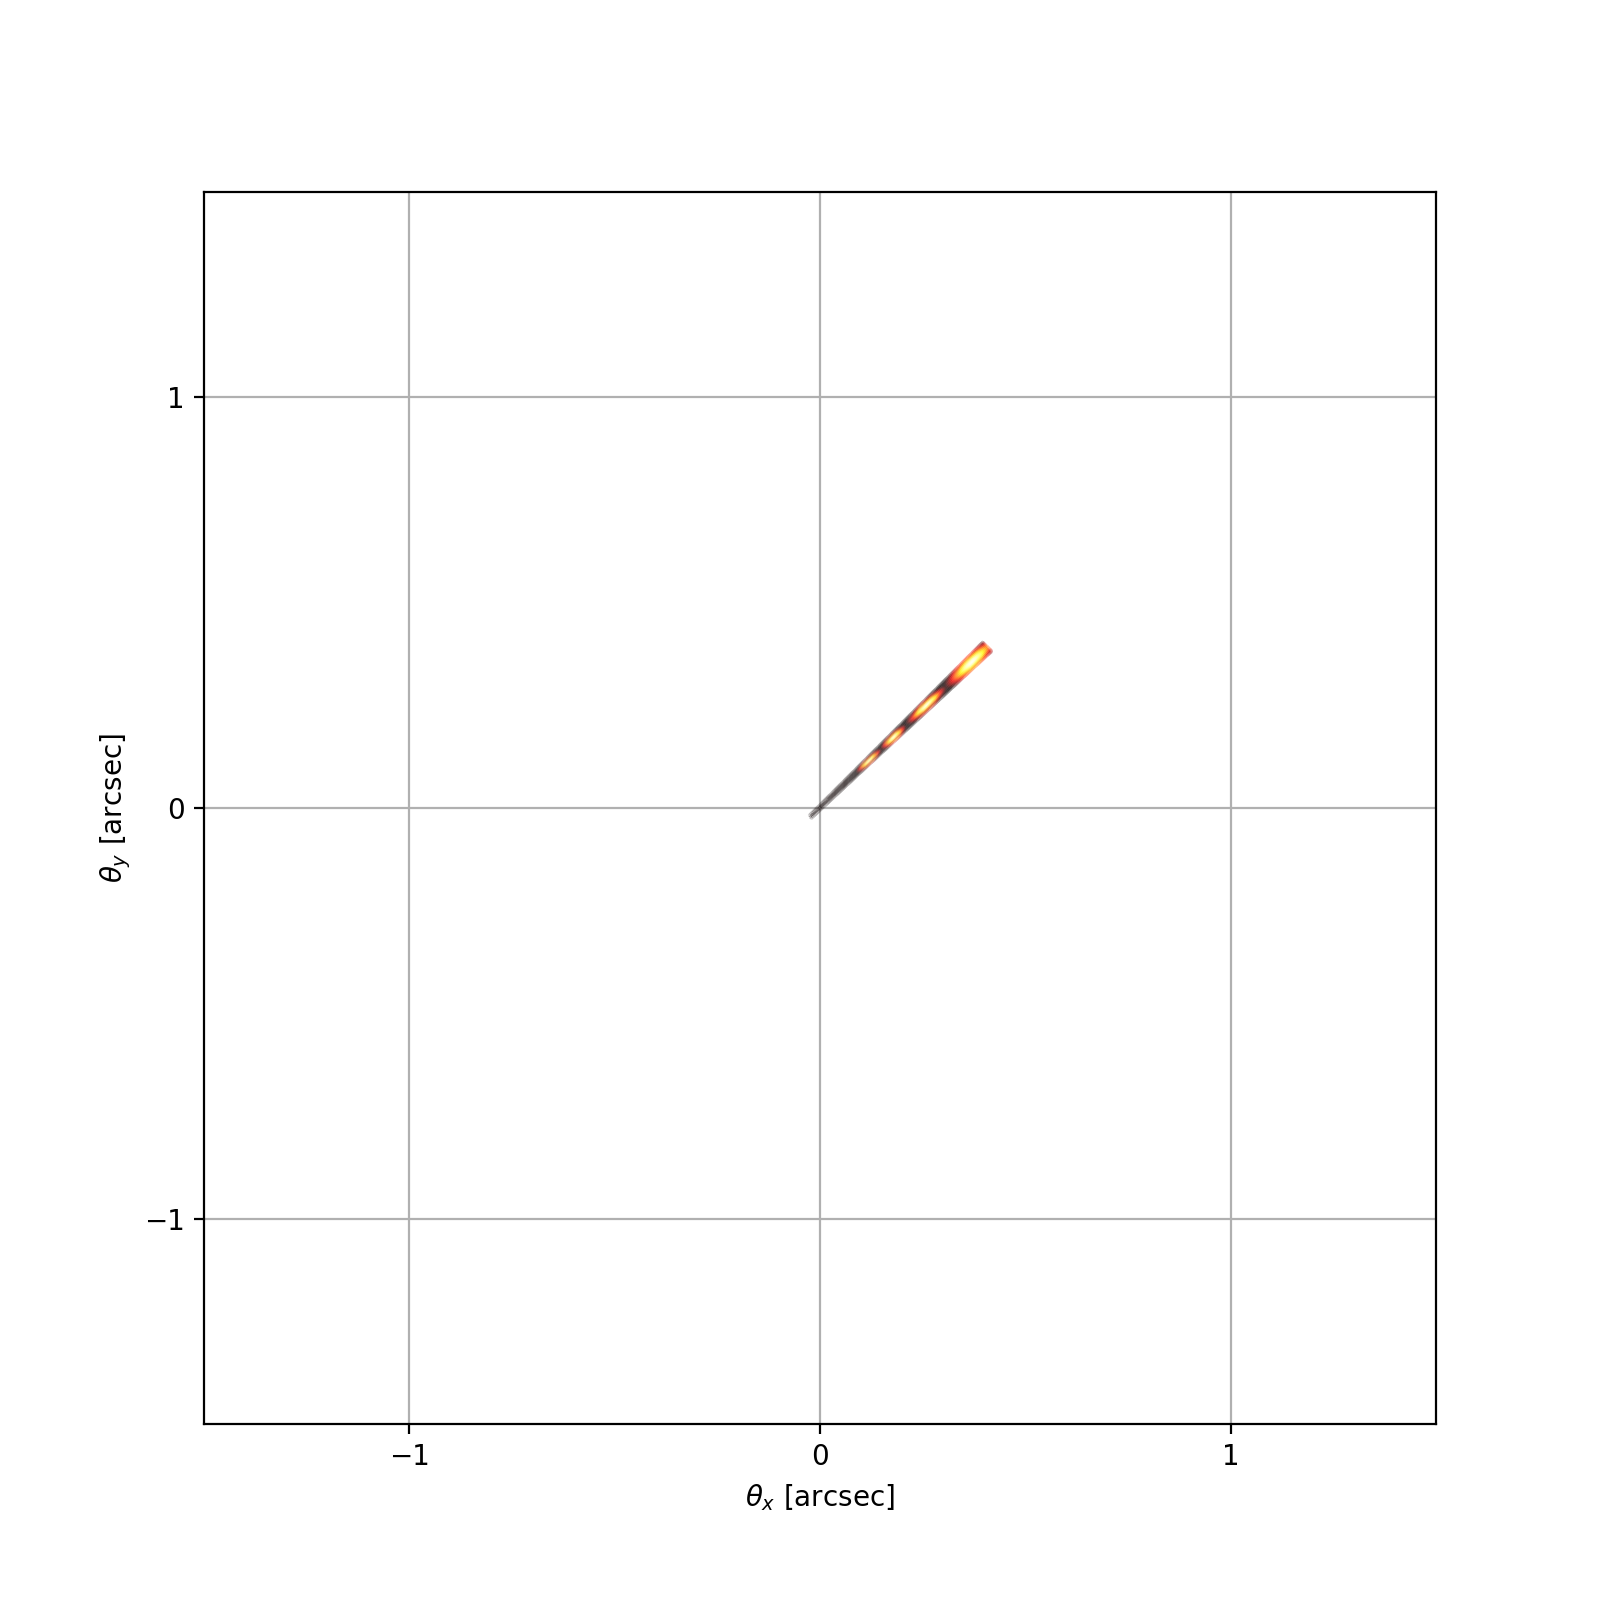

In [15]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))


plt.scatter(mesh_x,mesh_y, s =.002, c=mesh_light, cmap='hot',zorder = 2)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.grid()
plt.show()

In [33]:
start_jet = time.time()
delta_rs = 0.01
delta_r_arr = []

for x, y, z in zip(mesh_x, mesh_y, mesh_light):
    deltab_10 = x
    deltab_20 = y
    sie_plasma = sieplasmajet(theta_E, r, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)
    sie_plasma.psi_plasma_func()
    sie_plasma.delta_r()
    delta_r_arr.append([sie_plasma.delta_r_1, sie_plasma.delta_r_2])

end_jet = time.time()

print(end_jet-start_jet)
    

0.9864065647125244


<IPython.core.display.Javascript object>


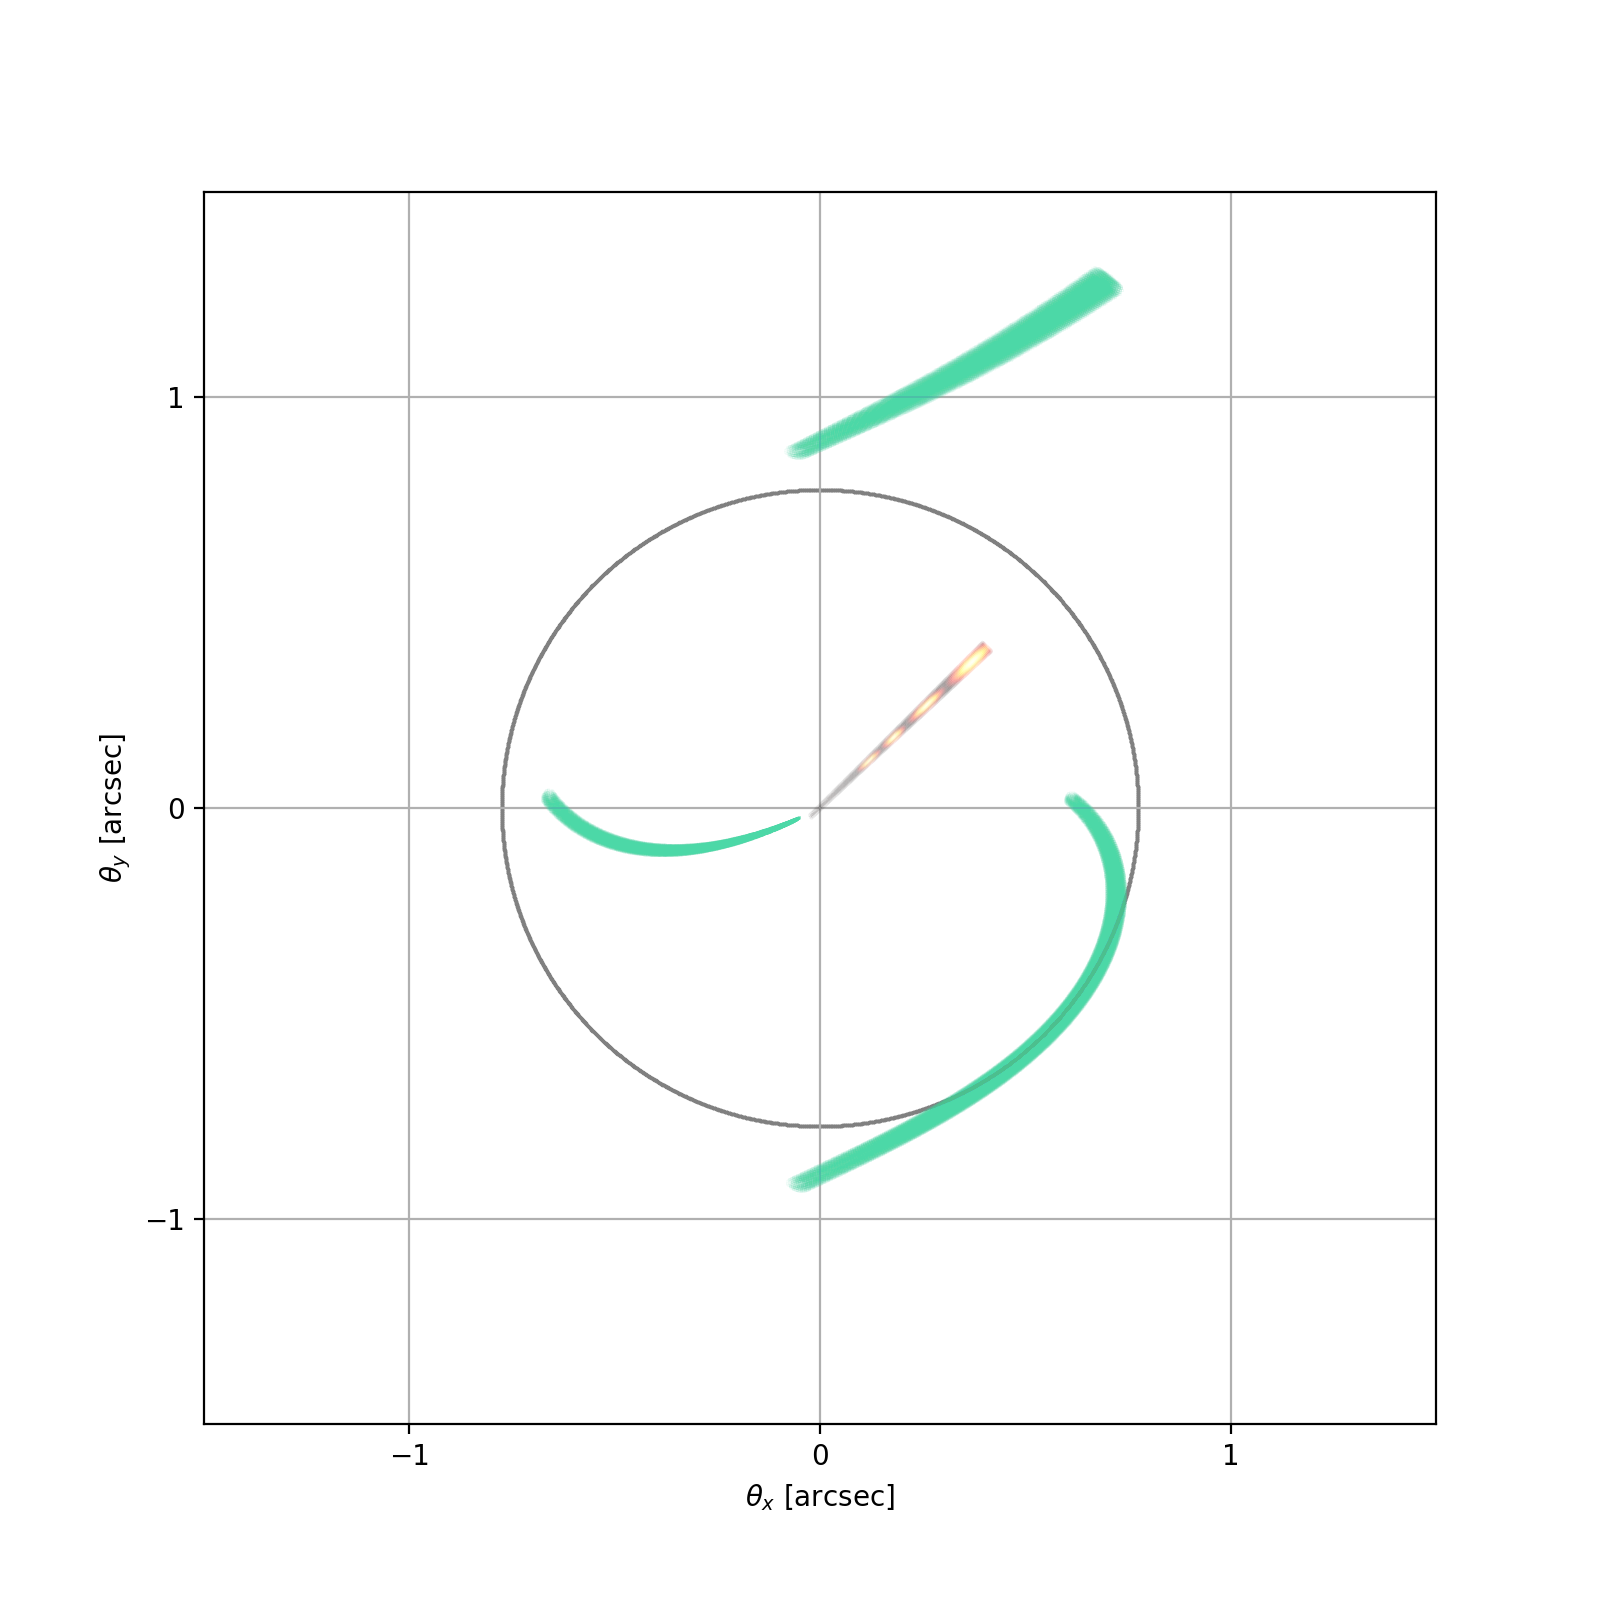

In [34]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

radii = r + delta_r_arr

plt.scatter(mesh_x,mesh_y, s =.0002, c=mesh_light, cmap='hot',zorder = 2)
plt.scatter(radii*np.cos(phi),radii*np.sin(phi),s = .0002,zorder = 2 , color = '#4cd8a7')
plt.scatter(r*np.cos(phi),r*np.sin(phi),s = .1,zorder = 1, color = 'grey')
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.grid()
plt.show()

In [32]:
np.shape(delta_r_arr)

(2566, 2, 3000)